## Utils

In [1]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1-koULT_rZz1E6VJJVYa-hnLXdy6XSZe2'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)

In [2]:
!unzip -q data.zip
!rm -rf data.zip

# Regression with RANSAC for Robust curve fitting

For a given polynomial, \\
$$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\cdots+\beta_{m} x_{i}^{m}+\varepsilon_{i}(i=1,2, \ldots, n)$$

we can express it in a form of matrix $\mathbf{X}$, a response vector or $\vec{y}$, a parameter vector $\vec{\beta}$, and a vector $\vec{\varepsilon}$ of random errors. The model can be represented as system of linear equations, i.e.



$$\left[\begin{array}{c}y_{1} \\ y_{2} \\ y_{3} \\ \vdots \\ y_{n}\end{array}\right]=\left[\begin{array}{ccccc}1 & x_{1} & x_{1}^{2} & \ldots & x_{1}^{m} \\ 1 & x_{2} & x_{2}^{2} & \ldots & x_{2}^{m} \\ 1 & x_{3} & x_{3}^{2} & \ldots & x_{3}^{m} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n} & x_{n}^{2} & \ldots & x_{n}^{m}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \vdots \\ \beta_{m}\end{array}\right]+\left[\begin{array}{c}\varepsilon_{1} \\ \varepsilon_{2} \\ \varepsilon_{3} \\ \vdots \\ \varepsilon_{n}\end{array}\right]$$

$$or$$

$$\vec{y}=\mathbf{X} \vec{\beta}+\vec{\varepsilon}$$

For this system, we can calculate $\vec{\beta}$ by using the following formula,
$$
\widehat{\vec{\beta}}=\left(\mathbf{X}^{\top} \mathbf{X}\right)^{-1} \mathbf{X}^{\top} \vec{y}
$$

Using **RANSAC**, we want to avoid outliers in our curve fitting, and thus we will calculate multiple $\vec{\beta_i}$s using a set of datapoints. After calculating several $\vec{\beta_i}$ we will find the best value of ${\beta}$ using _least squares_.

In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils.random import sample_without_replacement

In [4]:
class Regression:
    def __init__(self,order,bias=True):
        """
        Initialize regressor
        :param order: order of the polynomial
        :param bias: boolean, True for our case
        """

        # Initializing variables
        self.order = order
        self.bias = bias
        self.beta = np.zeros(order + bias)
        self.iterations = 0
        self.prob = 0.99

    # Predict equation using polyfit
    def predict(self, x):
        poly_eqn = np.poly1d(self.beta)
        y_hat = poly_eqn(x)

        return y_hat

    
    def solve(self,x,y,n,iterations=10000):
        '''
        Function to solve regression using RANSAC
        :param x: input
        :param y: output
        :param n: number of dataset per iteration
        :param iterations: number of iterations to find best beta 
        '''
        
        # Generate random seed
        seed = np.random.RandomState(0)

        # Initialize variables
        close_points = 1
        best_err = np.inf
        self.best_coord = None
        best_fit_x = None
        best_fit_y = None
        self.max_itr = iterations
        self.threshold = np.median(np.abs(y - np.median(y)))

        # Initialize coordinate array
        x_coord = np.array([i for i in range(len(x))])

        # Loop for maximum number of iterations
        while self.iterations < self.max_itr:
            # Sample random points to be inliers
            maybeInliers = sample_without_replacement(len(x), n, random_state=seed)

            # Find the coefficients for this model
            self.beta = np.polyfit(x, y, self.order)

            # Find the equation for model and errors
            maybeModel = self.predict(x)
            error = np.abs(y - maybeModel)

            # Find coordinates of points having error less than threshold
            coord = np.zeros(len(error), dtype=bool)

            for i in range(0,len(error)):
                if (error[i] <= self.threshold):
                    coord[i] = True

            # Find also inlier points
            alsoInliers = x_coord[coord]
            len_alsoInliers = len(alsoInliers)

            # If number of inlier points are greater
            if (len_alsoInliers >= close_points):
                # Find mean squared error in new and old model
                model_err = mean_squared_error(y[alsoInliers], self.predict(x[alsoInliers]))

                # If error for current model is less and have more points
                if (len_alsoInliers > close_points or model_err < best_err):
                    # Update model parameters
                    close_points = len_alsoInliers
                    best_err = model_err
                    self.best_coord = coord
                    best_fit_x = x[alsoInliers]
                    best_fit_y = y[alsoInliers]

                    # Update maximum iterations
                    w = close_points / float(len(x))

                    if (self.prob != 0 and w != 0):
                        k = np.log(1 - self.prob) / np.log(1 - w**n)
                        k = abs(float(np.ceil(k)))
                        self.max_itr = min(self.max_itr, k)

            # Increase iterations
            self.iterations += 1

        # Find final coefficients
        self.beta = np.polyfit(best_fit_x, best_fit_y, self.order)
        
        return self.beta,best_err
    

    def visualize(self, x, y, y_ransac, y_polyfit, show=False):
        '''
        function to visualize datapoints and optimal solution.
        '''
        
        # Plot figures
        plt.figure(figsize =(12, 8), dpi = 100)
        plt.plot(x, y, 'gx')
        plt.plot(x[self.best_coord], y[self.best_coord], 'o', color ='deepskyblue')
        plt.plot(x, y_ransac, 'r-')
        plt.plot(x, y_polyfit, '-', color='black')
        plt.legend(['Outliers','Inliers','RANSAC Estimated Curve','Polyfit Estimated Curve'])
        
        if show:
            plt.show()

## Solve and Visualize for 2nd Order

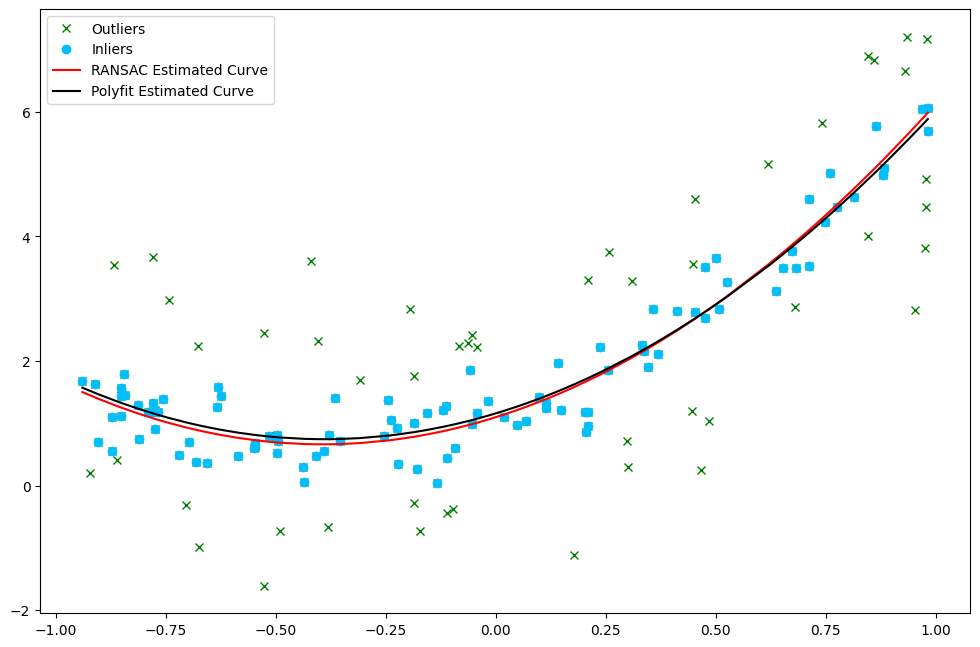

The coefficients are:  [2.816757 2.215295 1.097521]
The least square error is: 0.150906


In [5]:
# Load data
eqn = pd.read_csv("2nd_order.csv").to_numpy()
eqn = eqn[eqn[:, 0].argsort()]
x_2nd = eqn[:,0]
y_2nd = eqn[:,1]
np.set_printoptions(precision = 6)

# Find RANSAC model
ransac_2nd = Regression(2)
beta_2nd,error_2nd = ransac_2nd.solve(x_2nd, y_2nd, 2)
y_ransac_2nd = ransac_2nd.predict(x_2nd)

# Find polyfit model
beta_polyfit_2nd = np.polyfit(x_2nd, y_2nd, 2)
poly_2nd = np.poly1d(beta_polyfit_2nd)
y_polyfit_2nd = poly_2nd(x_2nd)

# Plot figures
ransac_2nd.visualize(x_2nd,y_2nd,y_ransac_2nd,y_polyfit_2nd,True)

print("The coefficients are: ", beta_2nd)
print("The least square error is: {0:.6f}".format(error_2nd))

## Solve and Visualize for 3rd Order

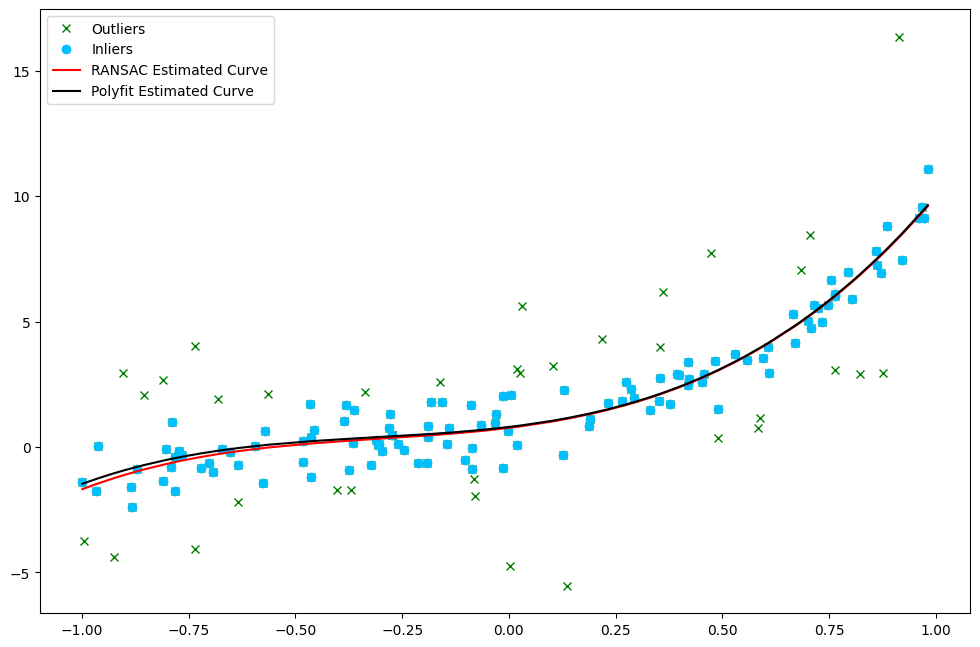

The coefficients are:  [3.711872 3.375541 2.11151  0.760716]
The least square error is: 0.564324


In [6]:
# Load data
eqn = pd.read_csv("3rd_order.csv").to_numpy()
eqn = eqn[eqn[:, 0].argsort()]
x_3rd = eqn[:,0]
y_3rd = eqn[:,1]
np.set_printoptions(precision = 6)

# Find RANSAC model
ransac_3rd = Regression(3)
beta_3rd,error_3rd = ransac_3rd.solve(x_3rd, y_3rd, 2)
y_ransac_3rd = ransac_3rd.predict(x_3rd)

# Find polyfit model
beta_polyfit_3rd = np.polyfit(x_3rd, y_3rd, 3)
poly_3rd = np.poly1d(beta_polyfit_3rd)
y_polyfit_3rd = poly_3rd(x_3rd)

# Plot figures
ransac_3rd.visualize(x_3rd,y_3rd,y_ransac_3rd,y_polyfit_3rd,True)

print("The coefficients are: ", beta_3rd)
print("The least square error is: {0:.6f}".format(error_3rd))

## Solve and Visualize for 4th Order

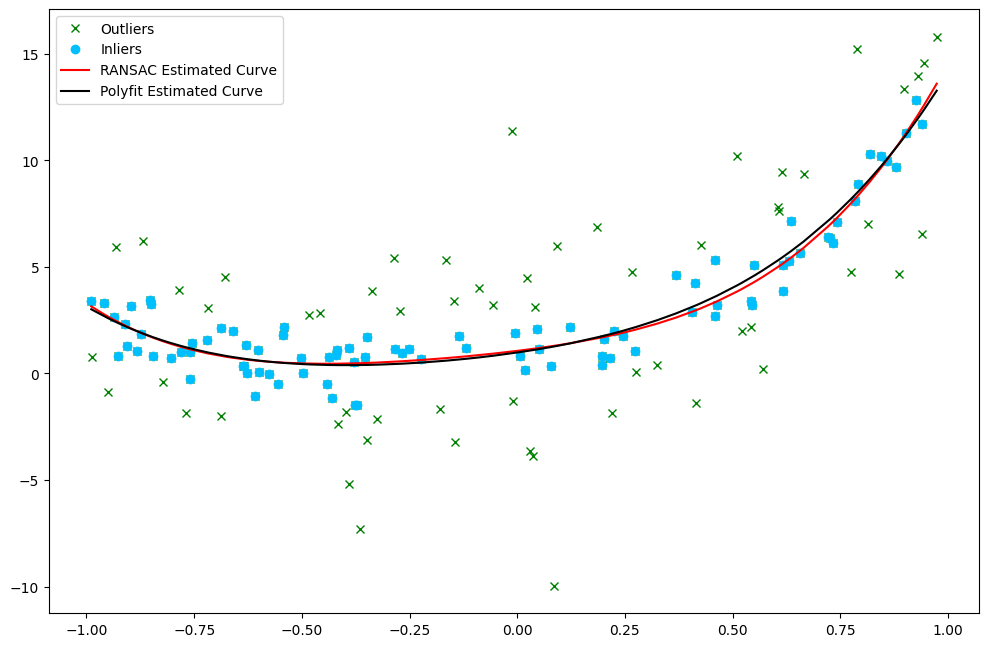

The coefficients are:  [4.922591 3.150595 2.942615 2.478553 1.059915]
The least square error is: 0.854029


In [7]:
# Load data
eqn = pd.read_csv("4th_order.csv").to_numpy()
eqn = eqn[eqn[:, 0].argsort()]
x_4th = eqn[:,0]
y_4th = eqn[:,1]
np.set_printoptions(precision = 6)

# Find RANSAC model
ransac_4th = Regression(4)
beta_4th,error_4th = ransac_4th.solve(x_4th, y_4th, 2)
y_ransac_4th = ransac_4th.predict(x_4th)

# Find polyfit model
beta_polyfit_4th = np.polyfit(x_4th, y_4th, 4)
poly_4th = np.poly1d(beta_polyfit_4th)
y_polyfit_4th = poly_4th(x_4th)

# Plot figures
ransac_4th.visualize(x_4th, y_4th, y_ransac_4th, y_polyfit_4th, True)

print("The coefficients are: ", beta_4th)
print("The least square error is: {0:.6f}".format(error_4th))